<a href="https://colab.research.google.com/github/danishkw/Computer-Vision---Image-Classification/blob/main/ComputerVision_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
from skimage import io
import cv2

In [2]:
# Load Google Drive to download dataset

from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/CS67_Fall2022_ A1_Dataset'):
    for filename in filenames:
        os.path.join(dirname, filename)


Mounted at /content/gdrive/


## **Supervised Approach**

In [3]:
# This block reads the text files (train.txt & test.txt) and training and testing images by stroing their path names in different lists

listTrain = []
listTest = []

Labels = os.listdir("/content/gdrive/MyDrive/CS67_Fall2022_ A1_Dataset")
Labels = [int(x) for x in Labels]

for root, dirs, files in os.walk("/content/gdrive/MyDrive/CS67_Fall2022_ A1_Dataset"):
   for folder in dirs:
     path = os.path.join(root, folder)

     # Prepare Trainset
     trainFile = open(path+"/train.txt", "r")
     trainList = trainFile.read().splitlines()
     labels = [folder]*len(trainList)

     listTuples_train = list(zip(trainList, labels))
     listTrain = listTrain + listTuples_train           #trainset


    # Prepare Testset
     testFile = open(path+"/test.txt", "r")
     testList = testFile.read().splitlines()
     labels = [folder]*len(testList)

     listTuples_test = list(zip(testList, labels))
     listTest = listTest + listTuples_test               #testset


In [4]:
# In this block, descriptors for training and testing images are found using SIFT. For both training and testing, 
# separate lists of lists are created to store image name, descriptor and label for every image.

descriptor_train = []
imgName = []
label = []

listTuples_train = []

for item in listTrain:
  image_path = "/content/gdrive/MyDrive/CS67_Fall2022_ A1_Dataset/" + item[1] + "/" + item[0]

  img = cv2.imread(image_path, 0)
  # cv2_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  cv2_image = cv2.resize(img,(128,128))
  # cv2_image = cv2.resize(img,(150,150))

  sift = cv2.xfeatures2d.SIFT_create()
  keypoints_sift, descriptors = sift.detectAndCompute(cv2_image, None)

  listTuples_train.append((image_path, descriptors.astype('float'), item[1]))


descriptor_test = []
imgName = []
label = []
listTuples_test = []


for itm in listTest:
  image_path = "/content/gdrive/MyDrive/CS67_Fall2022_ A1_Dataset/" + itm[1] + "/" + itm[0]

  img = cv2.imread(image_path, 0)
  # cv2_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  cv2_image = cv2.resize(img,(128,128))
  # cv2_image = cv2.resize(img,(150,150))

  sift = cv2.xfeatures2d.SIFT_create()
  keypoints_sift, descriptors = sift.detectAndCompute(cv2_image, None)

  listTuples_test.append((image_path, descriptors.astype('float'), itm[1]))

listTuples_train = np.array(listTuples_train)
listTuples_test = np.array(listTuples_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [5]:
# Converting lists of tuples into pandas Dataframe

df_train = pd.DataFrame(listTuples_train, columns = ['Image Name', 'Feature Vector', 'Label'])
df_test = pd.DataFrame(listTuples_test, columns = ['Image Name', 'Feature Vector', 'Label'])

In [6]:
# Using vstack to stack up descriptors
train_descriptors = []

train_descriptors = listTuples_train[0,1]
for train_descript in listTuples_train[:,1]:
  # train_descriptors.append(np.vstack(train_descript))
  train_descriptors = np.vstack((train_descriptors, train_descript))

trainData = {
  "Image Name": listTuples_train[:,0],
  "Vstacked Feature Vector": descriptors,
  "Label": listTuples_train[:,2]
}

test_descriptors = []
test_descriptors = listTuples_test[0,1]
for test_descript in listTuples_test[:,1]:
  # test_descriptors.append(np.vstack(test_descript))
  test_descriptors = np.vstack((test_descriptors, test_descript))

testData = {
  "Image Name": listTuples_test[:,0],
  "Vstacked Feature Vector": descriptors,
  "Label": listTuples_test[:,2]
}


In [7]:
# Applying K-Means to cluster descriptors and then create histograms for every image in trainset


from scipy.cluster.vq import kmeans, vq

image_count_train = len(listTuples_train)
no_clusters = 10 * image_count_train

k = 100  #k means with 100 clusters gives lower accuracy for the aeroplane example
voc, variance = kmeans(train_descriptors, no_clusters, 1) 

# Calculate the histogram of features and represent them as vector
#vq Assigns codes from a code book to observations.
im_features = np.zeros((image_count_train, no_clusters))
for i in range(image_count_train):
    words, distance = vq(listTuples_train[i][1],voc)
    for w in words:
        im_features[i][w] += 1


# Preparing test data for the classifier 
# test
image_count_test = len(listTuples_test)

test_features = np.zeros((image_count_test, no_clusters))
for i in range(image_count_test):
    words, distance = vq(listTuples_test[i][1],voc)
    for w in words:
        test_features[i][w] += 1

In [8]:
# Perform Tf-Idf vectorization for train
nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*image_count_train+1) / (1.0*nbr_occurences + 1)), 'float32')


# Perform Tf-Idf vectorization for test
nbr_occurences = np.sum( (test_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0 * image_count_test + 1) / (1.0*nbr_occurences + 1)), 'float32')

In [9]:
# Scaling the training data
from sklearn.preprocessing import StandardScaler

stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

# Scaling the testing data
test_features = stdSlr.transform(test_features)


In [10]:
# Learning and Classification

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import svm
dct = dict()

X_train = im_features
y_train = np.array(listTuples_train[:,2])
                   
X_test = test_features
y_test = np.array(listTuples_test[:,2])

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel
pipe = Pipeline([('model', clf)])


model = clf.fit(X_train, y_train)

prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)




accuracy: 84.0%


In [ ]:
# Displaying Misclassified images

misclassified = []
for im in range(len(y_test)):
  if y_test[im] != prediction[im]:
    misclassified.append(im)

imagePath = np.array(listTuples_test[:,0])
plt.axis('off')
# fig, axes = plt.subplot(5,4)
plt.figure(figsize=(10, 10))
%matplotlib inline
num = 1
for imgg in misclassified:
  
  img = cv2.imread(imagePath[imgg], -1)
  cv2_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(3,8,num)
  plt.imshow(cv2_image)
  plt.axis('off')
  num = num+1
  
plt.title("Misclassified Images")


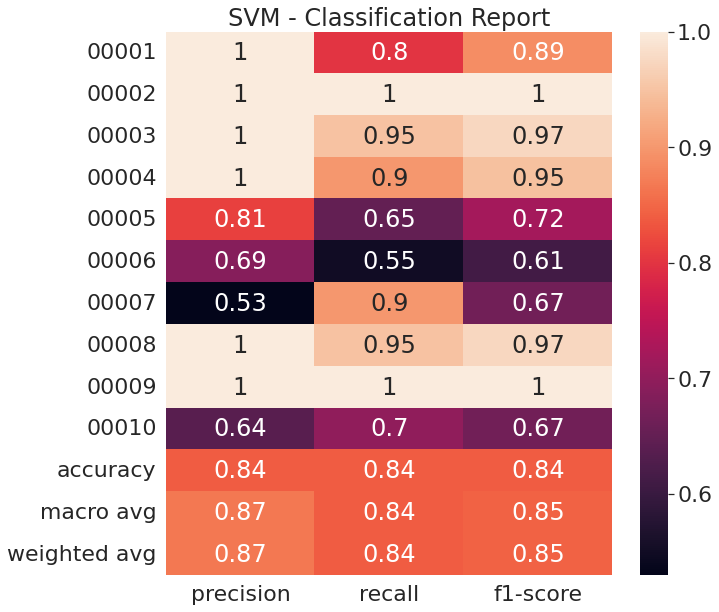

In [14]:
# Displaying classification report

from sklearn.metrics import classification_report
import seaborn as sns
sns.set_style('darkgrid')

true = np.random.randint(0, 10, size=100)
pred = np.random.randint(0, 10, size=100)
labels = np.arange(10)

clf_report = classification_report(y_test, prediction, output_dict=True)

plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title("SVM - Classification Report");

Normalized confusion matrix


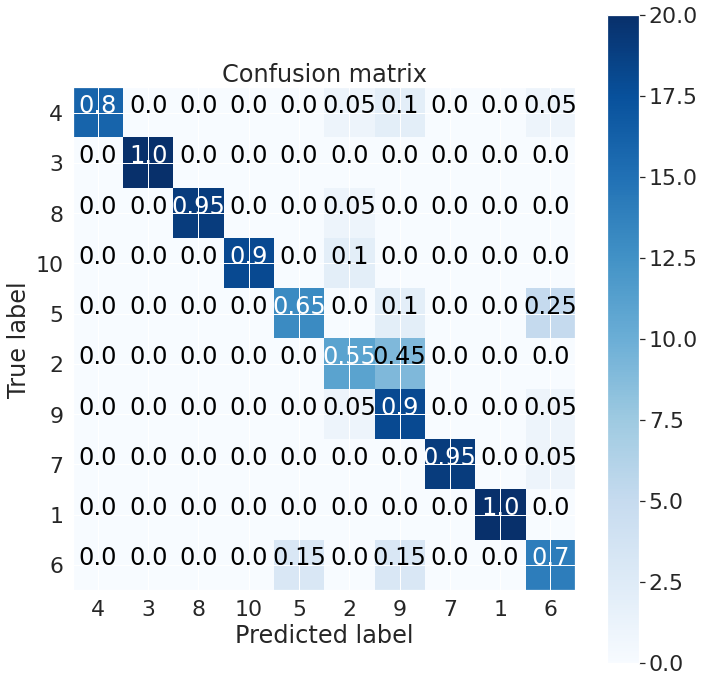

In [15]:
# Displaying confusion matrix

from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

fig, ax = plt.subplots(figsize=(10, 10))
cm = metrics.confusion_matrix(y_test, prediction)
# plot_confusion_matrix(cm, classes=Labels)

plot_confusion_matrix(cm, classes=Labels, normalize=True)

## **Unsupervised Approach**

In [16]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# train_descriptors

kmeans_model = KMeans(n_clusters=10, max_iter=1000).fit(np.array(train_descriptors))

In [17]:
kmeans_centroids = kmeans_model.cluster_centers_
kmeans_centroids

array([[12.14671765,  5.92887189,  5.78508604, ..., 25.35640535,
         1.96902486,  2.93932441],
       [43.79590288, 16.53915023,  7.62124431, ..., 18.73793627,
         7.68103187,  9.74127466],
       [64.22219823, 27.94601598,  9.13193695, ...,  7.85359534,
         8.21399266, 11.38026344],
       ...,
       [13.24471864, 10.13516545, 10.10880538, ...,  6.59169938,
         6.84352215,  8.6414283 ],
       [17.65656095, 19.10727612, 19.45553483, ..., 25.92521766,
        20.7716107 , 15.77876244],
       [18.62124331, 11.07431042, 15.09365994, ..., 14.83038287,
        18.98929601, 21.97529848]])

In [18]:
# pred_clusters = kmeans_model.predict(train_descriptors.reshape(-1,1))
pred_clusters = kmeans_model.fit_predict(listTuples_train[:,2].reshape(-1, 1))

In [19]:

labelList = [int(t) - 1 for t in listTuples_train[:,2]]
data = {
  "Image Name": listTuples_train[:,0],
  "Actual Label": labelList,
  "Predicted Label": pred_clusters
}

df_data = pd.DataFrame(data)

count = 0
for numb in range(len(df_data)):
  if df_data["Actual Label"][numb] != df_data["Predicted Label"][numb]:
    count = count + 1
print(count)

800


In [20]:
df_data

,Image Name,Actual Label,Predicted Label
0,/content/gdrive/MyDrive/CS67_Fall2022_ A1_Data...,3,4
1,/content/gdrive/MyDrive/CS67_Fall2022_ A1_Data...,3,4
2,/content/gdrive/MyDrive/CS67_Fall2022_ A1_Data...,3,4
3,/content/gdrive/MyDrive/CS67_Fall2022_ A1_Data...,3,4
4,/content/gdrive/MyDrive/CS67_Fall2022_ A1_Data...,3,4
...,...,...,...
795,/content/gdrive/MyDrive/CS67_Fall2022_ A1_Data...,5,3
796,/content/gdrive/MyDrive/CS67_Fall2022_ A1_Data...,5,3
797,/content/gdrive/MyDrive/CS67_Fall2022_ A1_Data...,5,3
798,/content/gdrive/MyDrive/CS67_Fall2022_ A1_Data...,5,3
